In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
import turing as tu
from turing.utils import *
import turing.loss_functions as tu_loss

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [2]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [4]:
model_params_1 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']

In [6]:
pinn = tu.NN(layers, lb, ub)
loss_stack_1 = [tu_loss.Observations(pinn, obs_X, obs_Y),
                tu_loss.ASDM(pinn, pde_X, init_loss_weight = 1.0)
               ]

In [7]:
model_1 = tu.TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())
#model_1.optimizer.learning_rate=1e-4

In [ ]:
arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train(25000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 0.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

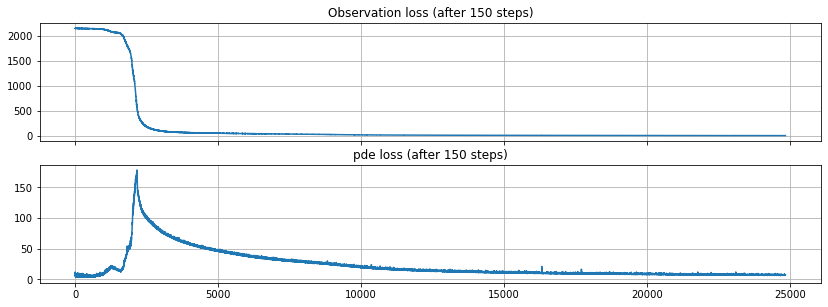

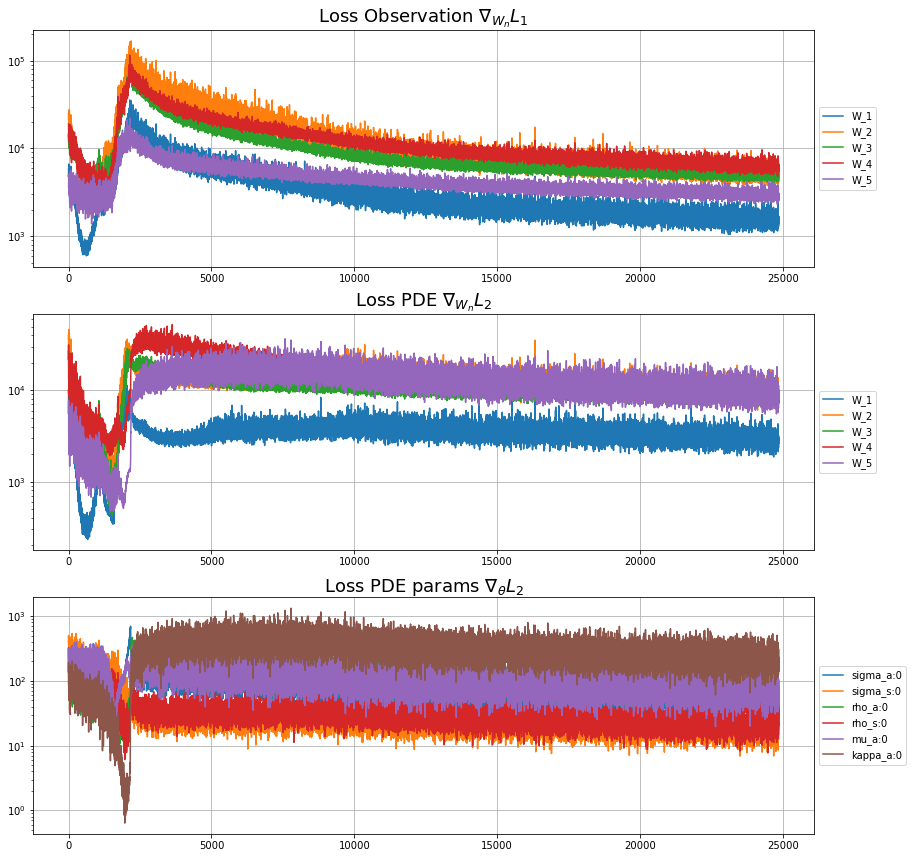

In [13]:
start = 150
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.title(f"Observation loss (after {start} steps)")
plt.plot(arr_losses_1[start:,0])
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.grid()
plt.subplot(4,1,2)
plt.title(f"pde loss (after {start} steps)")
plt.plot(arr_losses_1[start:,1])
plt.grid()
plt.show()


_ = plt.figure(figsize=(14,20))

plt.subplot(4,1,1)
plt.title(r"Loss Observation $\nabla_{W_n} L_1$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,0,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,2)
plt.title(r"Loss PDE $\nabla_{W_n} L_2$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,1,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.title(r"Loss PDE params $\nabla_{\theta} L_2$", fontsize=18)
for j in range(params_len):
    plt.plot(samples_grads_1[start:,1,j+2*W_n], label=f"{param_names[j]}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
arr_losses_2, samples_params_2, samples_grads_2 = \
         model_1.train(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 0.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:14.11
Loss_observations:6.96037507 
Loss_ASDM:7.14970443 sigma_a:0:0.16403370, sigma_s:0:0.07375343, rho_a:0:2.24485517, rho_s:0:0.07211509, mu_a:0:2.41329908, kappa_a:0:0.24866353
Time:0.25

Epoch: 100, loss:13.47
Loss_observations:6.90146762 
Loss_ASDM:6.57266673 sigma_a:0:0.16285864, sigma_s:0:0.07346488, rho_a:0:2.24258828, rho_s:0:0.07258013, mu_a:0:2.41034722, kappa_a:0:0.24864180
Time:199.12

Epoch: 200, loss:13.53
Loss_observations:6.82805073 
Loss_ASDM:6.70187497 sigma_a:0:0.16240172, sigma_s:0:0.07398186, rho_a:0:2.24052072, rho_s:0:0.07212663, mu_a:0:2.40789843, kappa_a:0:0.24880731
Time:202.04

Epoch: 300, loss:13.45
Loss_observations:6.80804154 
Loss_ASDM:6.63892794 sigma_a:0:0.16187060, sigma_s:0:0.07338558, rho_a:0:2.23857117, rho_s:0:0.07240062, mu_a:0:2.40505624, kappa_a:0:0.24886037
Time:189.40

Epoch: 400, loss:13.49
Loss_observations:6.78411096 
Loss_ASDM:6.70381692 sigma_a:0:0.16127281, sigma_s:0:0.07332745, rho_a:0:2.23694587, rho_s:0:0.07287977, mu

In [15]:
arr_losses_3, samples_params_3, samples_grads_3 = \
         model_1.train(10000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 0.0,
                       sample_stats=True,
                       sample_params=True,
                       sample_gradiants=True)

Epoch: 1, loss:12.98
Loss_observations:6.58465633 
Loss_ASDM:6.39502996 sigma_a:0:0.15768747, sigma_s:0:0.07336982, rho_a:0:2.22538614, rho_s:0:0.07265826, mu_a:0:2.38724709, kappa_a:0:0.24895915
Time:1.96

Epoch: 100, loss:13.51
Loss_observations:6.75205174 
Loss_ASDM:6.75544345 sigma_a:0:0.15744068, sigma_s:0:0.07318994, rho_a:0:2.22344995, rho_s:0:0.07304095, mu_a:0:2.38475680, kappa_a:0:0.24922785
Time:202.98

Epoch: 200, loss:14.66
Loss_observations:7.07049578 
Loss_ASDM:7.59297884 sigma_a:0:0.15692301, sigma_s:0:0.07296632, rho_a:0:2.22153425, rho_s:0:0.07293463, mu_a:0:2.38208532, kappa_a:0:0.24908152
Time:195.43

Epoch: 300, loss:13.40
Loss_observations:6.65173548 
Loss_ASDM:6.74388272 sigma_a:0:0.15603431, sigma_s:0:0.07343639, rho_a:0:2.21943069, rho_s:0:0.07290898, mu_a:0:2.37989640, kappa_a:0:0.24916944
Time:193.36

Epoch: 400, loss:12.97
Loss_observations:6.58656287 
Loss_ASDM:6.38225883 sigma_a:0:0.15548818, sigma_s:0:0.07383420, rho_a:0:2.21760559, rho_s:0:0.07269594, mu

Epoch: 3900, loss:12.30
Loss_observations:5.98139009 
Loss_ASDM:6.31603587 sigma_a:0:0.13879123, sigma_s:0:0.07414521, rho_a:0:2.15482640, rho_s:0:0.07371281, mu_a:0:2.29573607, kappa_a:0:0.25013605
Time:200.03

Epoch: 4000, loss:11.45
Loss_observations:5.69935998 
Loss_ASDM:5.74805021 sigma_a:0:0.13794647, sigma_s:0:0.07410928, rho_a:0:2.15310001, rho_s:0:0.07358444, mu_a:0:2.29331899, kappa_a:0:0.24992853
Time:199.28

Epoch: 4100, loss:11.86
Loss_observations:5.93265370 
Loss_ASDM:5.92713201 sigma_a:0:0.13760844, sigma_s:0:0.07473424, rho_a:0:2.15142417, rho_s:0:0.07292759, mu_a:0:2.29099631, kappa_a:0:0.25011379
Time:198.46

Epoch: 4200, loss:17.15
Loss_observations:8.44583151 
Loss_ASDM:8.69957677 sigma_a:0:0.13233648, sigma_s:0:0.07589316, rho_a:0:2.14820147, rho_s:0:0.07466522, mu_a:0:2.28699708, kappa_a:0:0.24868126
Time:198.94

Epoch: 4300, loss:15.22
Loss_observations:7.46986017 
Loss_ASDM:7.74992955 sigma_a:0:0.13143861, sigma_s:0:0.07610662, rho_a:0:2.15078211, rho_s:0:0.074

Epoch: 7800, loss:10.99
Loss_observations:5.38317069 
Loss_ASDM:5.61053908 sigma_a:0:0.11665769, sigma_s:0:0.07658084, rho_a:0:2.08770466, rho_s:0:0.07504699, mu_a:0:2.20703650, kappa_a:0:0.24996184
Time:205.28

Epoch: 7900, loss:12.89
Loss_observations:5.82106572 
Loss_ASDM:7.07033515 sigma_a:0:0.11626854, sigma_s:0:0.07635830, rho_a:0:2.08592367, rho_s:0:0.07529163, mu_a:0:2.20486188, kappa_a:0:0.25000894
Time:204.71

Epoch: 8000, loss:11.16
Loss_observations:5.35123974 
Loss_ASDM:5.80808118 sigma_a:0:0.11562127, sigma_s:0:0.07657528, rho_a:0:2.08382750, rho_s:0:0.07558003, mu_a:0:2.20324373, kappa_a:0:0.25000948
Time:205.41

Epoch: 8100, loss:10.67
Loss_observations:5.31823331 
Loss_ASDM:5.35583624 sigma_a:0:0.11532727, sigma_s:0:0.07627638, rho_a:0:2.08230805, rho_s:0:0.07575437, mu_a:0:2.20099163, kappa_a:0:0.24993378
Time:204.59

Epoch: 8200, loss:10.66
Loss_observations:5.21941498 
Loss_ASDM:5.43823567 sigma_a:0:0.11510617, sigma_s:0:0.07627107, rho_a:0:2.08055019, rho_s:0:0.075